In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.preprocessing import LabelEncoder
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report
import random

# Función para limpiar el texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Eliminar URLs
    text = re.sub(r'@\w+', '', text)     # Eliminar menciones
    text = re.sub(r'#\w+', '', text)     # Eliminar hashtags
    text = re.sub(r'\s+', ' ', text).strip()  # Normalizar espacios en blanco
    return text

# Cargar el archivo CSV de entrenamiento
df = pd.read_csv('sem_eval_train_es.csv')

# Aplicar limpieza de texto a los tweets
df['Cleaned_Text'] = df['Tweet'].apply(clean_text)

# Mostrar las primeras filas del dataframe con los textos procesados
print(df[['Tweet', 'Cleaned_Text']].head())

# Seleccionar un índice aleatorio
random_index = random.randint(0, len(df) - 1)

# Obtener el tweet aleatorio y sus emociones
tweet_row = df.iloc[random_index]
tweet_id = tweet_row['ID']
original_tweet = tweet_row['Tweet']
emotions = tweet_row.drop(labels=['Tweet', 'Cleaned_Text', 'ID'])
# Mostrar el texto original del tweet
print(f'Texto Original del Tweet (ID: {tweet_id}):')
print(original_tweet)

# Mostrar las emociones que son True
print('\nEmociones:')
for emotion, is_true in emotions.items():
    if is_true:  # Comprobar si la emoción está marcada como True
        print(emotion)

                                               Tweet  \
0  @aliciaenp Ajajjaa somos del clan twitteras pe...   
1  @AwadaNai la mala suerte del gato fichame la c...   
2  @audiomano A mí tampoco me agrado mucho eso. E...   
3  Para llevar a los bebes de un lugar a otro deb...   
4  @DalasReview me encanta la terrible hipocresia...   

                                        Cleaned_Text  
0  ajajjaa somos del clan twitteras perdidas pa e...  
1  la mala suerte del gato fichame la cara de hel...  
2  a mí tampoco me agrado mucho eso. especialment...  
3  para llevar a los bebes de un lugar a otro deb...  
4  me encanta la terrible hipocresia y doble mora...  
Texto Original del Tweet (ID: 2018-Es-03459):
@nahuivan15 innecesario comentario en mi opinión. Es q me ponia nerviosa man ataje mas q vos. 1 solo gol me hicieron

Emociones:
anger


In [2]:
# Definir características (X) y etiquetas (y)
X = df['Cleaned_Text']
y = df.iloc[:, 2:13]  # Seleccionar solo las columnas de etiquetas emocionales

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Convertir todas las etiquetas a cadenas de texto
y_train = y_train.astype(str)
y_test = y_test.astype(str)

# Contar el número de tweets por categoría en entrenamiento
print("\nNúmero de tweets por categoría en el conjunto de entrenamiento:")
for col in y_train.columns:
    print(f"{col}: {sum(y_train[col] == 'True')} tweets")

# Contar el número de tweets por categoría en prueba
print("\nNúmero de tweets por categoría en el conjunto de prueba:")
for col in y_test.columns:
    print(f"{col}: {sum(y_test[col] == 'True')} tweets")


Número de tweets por categoría en el conjunto de entrenamiento:
anger: 916 tweets
anticipation: 322 tweets
disgust: 415 tweets
fear: 293 tweets
joy: 885 tweets
love: 213 tweets
optimism: 299 tweets
pessimism: 461 tweets
sadness: 672 tweets
surprise: 123 tweets
trust: 145 tweets

Número de tweets por categoría en el conjunto de prueba:
anger: 239 tweets
anticipation: 93 tweets
disgust: 106 tweets
fear: 80 tweets
joy: 202 tweets
love: 48 tweets
optimism: 79 tweets
pessimism: 117 tweets
sadness: 173 tweets
surprise: 46 tweets
trust: 30 tweets


In [3]:
# Tokenizador preentrenado BERT para español
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

# Tokenizar textos de entrenamiento
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Convertir etiquetas a números usando LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.idxmax(axis=1))
y_test_encoded = label_encoder.transform(y_test.idxmax(axis=1))

# Crear tensores PyTorch para entrenamiento
input_ids_train = train_encodings['input_ids']
attention_masks_train = train_encodings['attention_mask']
labels_train = torch.tensor(y_train_encoded, dtype=torch.long)

# Crear tensores PyTorch para prueba
input_ids_test = test_encodings['input_ids']
attention_masks_test = test_encodings['attention_mask']
labels_test = torch.tensor(y_test_encoded, dtype=torch.long)

# Crear DataLoader para entrenamiento
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=32)

# Crear DataLoader para prueba
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [4]:
import nltk
# Descargar los recursos necesarios
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aderi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aderi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (pooler): BertPooler(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (activation): Tanh()
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(
    in_features=768, out_features=11, bias=True
    (dropout): Dropout(p=1.0, inplace=False)
  )
)
Learning rate: 1.5e-05
Weight decay: 1.0


In [5]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from nltk.corpus import wordnet
import random
import numpy as np

# Definir el dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo BERT base para clasificación con dropout
model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=11)

# Optimizador con regularización
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8, weight_decay=0.01)

# Ajustar dropout en las capas de atención y salidas del encoder
for i in range(12):  # iterar sobre las 12 capas del encoder
    # Ajustar dropout en la capa de atención
    #model.bert.encoder.layer[i].attention.self.dropout.p = 0.2

    # Ajustar dropout en la salida de la capa
    model.bert.encoder.layer[i].attention.output.dropout.p = 0.2
    model.bert.encoder.layer[i].output.dropout.p = 0.2

# Añadir dropout a la última capa de clasificación
model.classifier.dropout = torch.nn.Dropout(p=0.2)

model.to(device)

# Imprimir la configuración del modelo para verificar
print(model)



# Verificar parámetros del optimizador
for param_group in optimizer.param_groups:
    print(f'Learning rate: {param_group["lr"]}')
    print(f'Weight decay: {param_group["weight_decay"]}')
    

# Calcular las ponderaciones de clase
train_labels = []
for batch in train_dataloader:
    train_labels.extend(batch[2].tolist())

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Definir la función de pérdida con ponderaciones de clase
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Función para calcular la precisión
def accuracy(preds, labels):
    pred_flat = torch.argmax(preds, dim=1).flatten()
    labels_flat = labels.flatten()
    return torch.sum(pred_flat == labels_flat).item() / len(labels_flat)

# Funciones de data augmentation
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word, lang='spa'):
        for lemma in syn.lemmas(lang='spa'):
            synonym = lemma.name().replace('_', ' ')
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def random_deletion(words, p=0.1):
    if len(words) == 1:
        return words
    remaining = list(filter(lambda x: random.uniform(0, 1) > p, words))
    if len(remaining) == 0:
        return [random.choice(words)]
    return remaining

def random_swap(words, n=1):
    if len(words) < 2:
        return words
    words = words.copy()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return words

def data_augmentation(text):
    words = text.split()
    if random.uniform(0, 1) < 0.1:
        words = random_deletion(words)
    if random.uniform(0, 1) < 0.1:
        words = random_swap(words)
    if random.uniform(0, 1) < 0.1:
        new_words = []
        for word in words:
            synonyms = get_synonyms(word)
            if synonyms and random.uniform(0, 1) < 0.5:
                new_words.append(random.choice(synonyms))
            else:
                new_words.append(word)
        words = new_words
    return ' '.join(words)

# Función para entrenar el modelo y guardar el modelo al finalizar
def train_model(model, train_dataloader, optimizer, device, epochs, validation_dataloader=None, save_path=None, patience=3):
    print("Iniciando entrenamiento...")
    
    # Scheduler ReduceLROnPlateau para ajuste dinámico del learning rate
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.25, patience=3, verbose=True)

    best_val_accuracy = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_accuracy = 0

        for step, batch in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}')):
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)
            labels = batch[2].to(device)

            # Aplicar data augmentation a los textos
            texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]
            augmented_texts = [data_augmentation(text) for text in texts]
            
            augmented_inputs = tokenizer(augmented_texts, padding=True, truncation=True, return_tensors="pt").to(device)

            model.zero_grad()

            outputs = model(input_ids=augmented_inputs['input_ids'], attention_mask=augmented_inputs['attention_mask'])
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            total_loss += loss.item()
            total_accuracy += accuracy(logits, labels)

            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_dataloader)
        avg_accuracy = total_accuracy / len(train_dataloader)

        print(f'Época {epoch + 1}/{epochs}')
        print(f'Pérdida: {avg_loss:.4f} | Precisión: {avg_accuracy:.4f}')

        # Ajustar learning rate dinámicamente según la precisión de validación
        if validation_dataloader:
            model.eval()
            val_accuracy = 0
            for batch in validation_dataloader:
                input_ids = batch[0].to(device)
                attention_masks = batch[1].to(device)
                labels = batch[2].to(device)

                with torch.no_grad():
                    outputs = model(input_ids=input_ids, attention_mask=attention_masks)
                    logits = outputs.logits

                val_accuracy += accuracy(logits, labels)

            avg_val_accuracy = val_accuracy / len(validation_dataloader)
            print(f'Precisión de validación después de la época {epoch + 1}: {avg_val_accuracy:.4f}')

            # Actualizar learning rate según la precisión de validación
            scheduler.step(avg_val_accuracy)

            # Implementar early stopping
            if avg_val_accuracy > best_val_accuracy:
                best_val_accuracy = avg_val_accuracy
                patience_counter = 0
                # Guardar el mejor modelo
                if save_path:
                    torch.save(model.state_dict(), save_path)
                    print(f'Modelo guardado en {save_path}')
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f'No hubo mejora en la precisión de validación en {patience} épocas consecutivas. Deteniendo entrenamiento.')
                break

    print("Entrenamiento completado.")

train_model(model, train_dataloader, optimizer, device, epochs=50, validation_dataloader=test_dataloader, save_path='bert_model_spanish_bal.pt', patience=10)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\aderi\anaconda3\envs\tf-gpu\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

c:\Users\aderi\anaconda3\envs\tf-gpu\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 1/50
Pérdida: 2.3652 | Precisión: 0.1650
Precisión de validación después de la época 1: 0.3522
Modelo guardado en bert_model_spanish_bal.pt


Epoch 2/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 2/50
Pérdida: 2.0668 | Precisión: 0.3588
Precisión de validación después de la época 2: 0.3397


Epoch 3/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 3/50
Pérdida: 1.5814 | Precisión: 0.4596
Precisión de validación después de la época 3: 0.4102
Modelo guardado en bert_model_spanish_bal.pt


Epoch 4/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 4/50
Pérdida: 1.1920 | Precisión: 0.5281
Precisión de validación después de la época 4: 0.3765


Epoch 5/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 5/50
Pérdida: 0.9451 | Precisión: 0.5811
Precisión de validación después de la época 5: 0.4890
Modelo guardado en bert_model_spanish_bal.pt


Epoch 6/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 6/50
Pérdida: 0.7123 | Precisión: 0.6594
Precisión de validación después de la época 6: 0.4651


Epoch 7/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 7/50
Pérdida: 0.5631 | Precisión: 0.7223
Precisión de validación después de la época 7: 0.4610


Epoch 8/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 8/50
Pérdida: 0.4439 | Precisión: 0.7626
Precisión de validación después de la época 8: 0.4832


Epoch 9/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 9/50
Pérdida: 0.3652 | Precisión: 0.8153
Precisión de validación después de la época 9: 0.4915
Modelo guardado en bert_model_spanish_bal.pt


Epoch 10/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 10/50
Pérdida: 0.2711 | Precisión: 0.8599
Precisión de validación después de la época 10: 0.5332
Modelo guardado en bert_model_spanish_bal.pt


Epoch 11/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 11/50
Pérdida: 0.2739 | Precisión: 0.8539
Precisión de validación después de la época 11: 0.5221


Epoch 12/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 12/50
Pérdida: 0.2144 | Precisión: 0.8897
Precisión de validación después de la época 12: 0.5491
Modelo guardado en bert_model_spanish_bal.pt


Epoch 13/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 13/50
Pérdida: 0.2110 | Precisión: 0.9027
Precisión de validación después de la época 13: 0.5127


Epoch 14/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 14/50
Pérdida: 0.1690 | Precisión: 0.9175
Precisión de validación después de la época 14: 0.5679
Modelo guardado en bert_model_spanish_bal.pt


Epoch 15/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 15/50
Pérdida: 0.1362 | Precisión: 0.9308
Precisión de validación después de la época 15: 0.5627


Epoch 16/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 16/50
Pérdida: 0.1389 | Precisión: 0.9382
Precisión de validación después de la época 16: 0.5693
Modelo guardado en bert_model_spanish_bal.pt


Epoch 17/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 17/50
Pérdida: 0.1464 | Precisión: 0.9382
Precisión de validación después de la época 17: 0.5596


Epoch 18/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 18/50
Pérdida: 0.1481 | Precisión: 0.9393
Precisión de validación después de la época 18: 0.5596


Epoch 19/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 19/50
Pérdida: 0.1398 | Precisión: 0.9364
Precisión de validación después de la época 19: 0.5373


Epoch 20/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 20/50
Pérdida: 0.1155 | Precisión: 0.9522
Precisión de validación después de la época 20: 0.5554


Epoch 21/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 21/50
Pérdida: 0.0759 | Precisión: 0.9712
Precisión de validación después de la época 21: 0.5582


Epoch 22/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 22/50
Pérdida: 0.0639 | Precisión: 0.9782
Precisión de validación después de la época 22: 0.5651


Epoch 23/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 23/50
Pérdida: 0.0780 | Precisión: 0.9712
Precisión de validación después de la época 23: 0.5540


Epoch 24/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 24/50
Pérdida: 0.0740 | Precisión: 0.9772
Precisión de validación después de la época 24: 0.5665


Epoch 25/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 25/50
Pérdida: 0.0749 | Precisión: 0.9754
Precisión de validación después de la época 25: 0.5637


Epoch 26/50:   0%|          | 0/89 [00:00<?, ?it/s]

Época 26/50
Pérdida: 0.0681 | Precisión: 0.9772
Precisión de validación después de la época 26: 0.5596
No hubo mejora en la precisión de validación en 10 épocas consecutivas. Deteniendo entrenamiento.
Entrenamiento completado.


              precision    recall  f1-score   support

       anger       0.71      0.69      0.70       272
anticipation       0.47      0.38      0.42        77
     disgust       0.11      0.09      0.10        23
        fear       0.55      0.62      0.58        55
         joy       0.59      0.69      0.63       153
        love       0.38      0.38      0.38        16
    optimism       0.29      0.38      0.33        13
   pessimism       0.26      0.29      0.27        42
     sadness       0.44      0.33      0.38        48
    surprise       0.20      0.09      0.12        11
       trust       0.00      0.00      0.00         3

    accuracy                           0.56       713
   macro avg       0.36      0.36      0.36       713
weighted avg       0.55      0.56      0.55       713



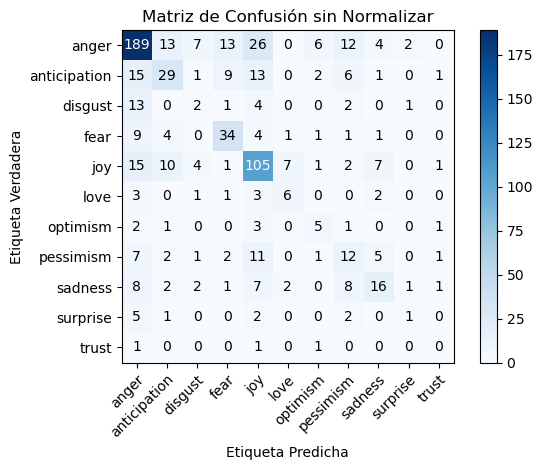

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Matriz de Confusión Normalizada'
        else:
            title = 'Matriz de Confusión sin Normalizar'

    # calcular confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    # Normalizar confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # imprimir confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta Verdadera',
           xlabel='Etiqueta Predicha')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


# Función para evaluar el modelo en el conjunto de prueba y mostrar la matriz de confusión
def evaluate_model(model, test_dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())

    # Convertir las etiquetas de vuelta al formato original
    y_true = label_encoder.inverse_transform(y_true)
    y_pred = label_encoder.inverse_transform(y_pred)

    # Mostrar métricas de clasificación
    print(classification_report(y_true, y_pred))

    # Mostrar matriz de confusión
    unique_labels = np.unique(y_true)
    plot_confusion_matrix(y_true, y_pred, classes=unique_labels)

evaluate_model(model, test_dataloader, device)

Se ha entrenado un modelo de clasificación de secuencias basado en BERT para español.
Se ha empleado el optimizador AdamW, y probado con diferentes hiperparámetros (LR, y wieght decay, también diferentes valores de dropout en diferentes capas del modelo).
También se ha probado diferentes schedulers para ir reduciendo el lr en función de la precisión de validación, y diferentes ratios entre tamaño de entrenamiento y test.

Pese a que se alcanza una pérdida baja y una precisión alta en el conjunto de entrenamiento, la precisión en el conjunto de validación es de 0,56.
El modelo tiene bastantes problemas en generalizar, quizás se deba a que el dataset de entrenamiento no es muy grande, y está bastante desbalanceado, habiendo muchos tweets categorizados como anger y joy, y pocos como trust, surprise y love.

Además, hay que tener en cuenta que el etiquetado es subjetivo, puesto que se trata de emociones, y no es fácil clasificar la intención del autor.

Se ha intentado compensar el desbalanceo del dataset asignando pesos, y se ha recurrido a técnicas de data augmentation, aunque no han mejorado mucho los resultados.
Se ha probado diferentes valores de hiperparámetros, como el LR

El modelo muestra un buen rendimiento en la clasificación de emociones como "anger" (enojo) y "joy" (alegría), con F1-scores superiores a 0.60.
Emociones como "disgust" (disgusto), "surprise" (sorpresa) y "trust" (confianza) tienen un desempeño muy pobre, con F1-scores cercanos a 0.
La precisión global (accuracy) del 56% es aceptable, pero la baja macro average indica que el modelo tiene problemas significativos con varias emociones.

Número de tweets por categoría en el conjunto de entrenamiento:
anger: 916 tweets
anticipation: 322 tweets
disgust: 415 tweets
fear: 293 tweets
joy: 885 tweets
love: 213 tweets
optimism: 299 tweets
pessimism: 461 tweets
sadness: 672 tweets
surprise: 123 tweets
trust: 145 tweets




In [14]:
# Cargar el conjunto de evaluación ciego
eval_df = pd.read_csv('sem_eval_test_blank_es.csv')

# Limpiar el texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Eliminar URLs
    text = re.sub(r'@\w+', '', text)     # Eliminar menciones
    text = re.sub(r'#\w+', '', text)     # Eliminar hashtags
    text = re.sub(r'\s+', ' ', text).strip()  # Normalizar espacios en blanco
    return text

eval_df['Cleaned_Text'] = eval_df['Tweet'].apply(clean_text)

# Tokenizar textos de prueba
test_encodings = tokenizer(list(eval_df['Cleaned_Text']), truncation=True, padding=True, max_length=150, return_tensors='pt')

# Crear tensores PyTorch para prueba
input_ids_test = test_encodings['input_ids']
attention_masks_test = test_encodings['attention_mask']

# Crear DataLoader para el conjunto de evaluación ciego
eval_dataset = TensorDataset(input_ids_test, attention_masks_test)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

# Función para evaluar el modelo en el conjunto de evaluación
def predict_model(model, eval_dataloader, device):
    model.eval()
    predictions = []

    for batch in eval_dataloader:
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits

        # Añadir las predicciones sin aplicar la función de activación
        predictions.extend(logits.cpu().numpy())

    return predictions

# Generar predicciones
predictions = predict_model(model, eval_dataloader, device)

# Aplicar la función de activación (sigmoid) para la clasificación multietiqueta
sigmoid = torch.nn.Sigmoid()
predictions = sigmoid(torch.tensor(predictions)).numpy()

# Convertir predicciones a etiquetas binarias (umbral 0.5)
pred_labels = (predictions > 0.5)

# Crear DataFrame de resultados
results_df = pd.DataFrame(pred_labels, columns=[
    'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'
])

# Insertar la columna ID desde el DataFrame original
results_df.insert(0, 'ID', eval_df['ID'])

# Guardar el DataFrame como un archivo CSV
output_filename = 'soluciones_Adrian_Garcia_Domingo.csv'
results_df.to_csv(output_filename, index=False)

print(f'Resultados guardados en {output_filename}')


Resultados guardados en soluciones_Adrian_Garcia_Domingo.csv


In [15]:
# Cargar el archivo CSV generado
df2 = pd.read_csv('soluciones_Adrian_Garcia_Domingo.csv')

# Mostrar información básica del DataFrame
print(df2.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            679 non-null    object
 1   anger         679 non-null    bool  
 2   anticipation  679 non-null    bool  
 3   disgust       679 non-null    bool  
 4   fear          679 non-null    bool  
 5   joy           679 non-null    bool  
 6   love          679 non-null    bool  
 7   optimism      679 non-null    bool  
 8   pessimism     679 non-null    bool  
 9   sadness       679 non-null    bool  
 10  surprise      679 non-null    bool  
 11  trust         679 non-null    bool  
dtypes: bool(11), object(1)
memory usage: 12.7+ KB
None


In [16]:
# Contar la cantidad de tweets por cada emoción
anger_count = results_df['anger'].sum()
anticipation_count = results_df['anticipation'].sum()
disgust_count = results_df['disgust'].sum()
fear_count = results_df['fear'].sum()
joy_count = results_df['joy'].sum()
love_count = results_df['love'].sum()
optimism_count = results_df['optimism'].sum()
pessimism_count = results_df['pessimism'].sum()
sadness_count = results_df['sadness'].sum()
surprise_count = results_df['surprise'].sum()
trust_count = results_df['trust'].sum()

# Mostrar los resultados
print(f'Cantidad de tweets por emoción:')
print(f'Anger: {anger_count}')
print(f'Anticipation: {anticipation_count}')
print(f'Disgust: {disgust_count}')
print(f'Fear: {fear_count}')
print(f'Joy: {joy_count}')
print(f'Love: {love_count}')
print(f'Optimism: {optimism_count}')
print(f'Pessimism: {pessimism_count}')
print(f'Sadness: {sadness_count}')
print(f'Surprise: {surprise_count}')
print(f'Trust: {trust_count}')



# Seleccionar un índice aleatorio
random_index = random.randint(0, len(results_df) - 1)

# Obtener el texto original y las emociones predichas
tweet_id = results_df.iloc[random_index]['ID']
original_tweet = eval_df[eval_df['ID'] == tweet_id]['Tweet'].values[0]
predicted_emotions = results_df.iloc[random_index, 1:]  # Excluir la columna ID

# Mostrar el texto original del tweet
print(f'Texto Original del Tweet (ID: {tweet_id}):')
print(original_tweet)

# Mostrar las emociones predichas que son True
print('\nEmociones Predichas:')
for emotion, is_true in predicted_emotions.items():
    if is_true:
        print(emotion)


Cantidad de tweets por emoción:
Anger: 573
Anticipation: 243
Disgust: 133
Fear: 202
Joy: 468
Love: 62
Optimism: 127
Pessimism: 195
Sadness: 171
Surprise: 78
Trust: 45
Texto Original del Tweet (ID: 2018-Es-04091):
Mujeres que tienen nombre de perras y le hacen honor a el 😅

Emociones Predichas:
anger
joy
